In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

train_pca = pd.read_csv('train_pca.csv')
del train_pca['Unnamed: 0']
train_pca

,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
0,-0.346579,0.098145,-0.806746,-0.427913,0.328098
1,-1.618868,-0.365689,0.405130,-0.254094,-0.970461
2,-0.763450,-0.721884,0.720200,0.806694,0.062175
3,-0.506804,0.166461,-0.184220,1.056516,-0.478649
4,7.945215,-0.716464,-1.416758,-0.013609,0.743721
...,...,...,...,...,...
15920,0.898226,-2.430100,0.605703,-0.643798,0.342123
15921,-0.837187,-1.080911,1.081214,1.001772,-0.389527
15922,5.465723,0.093960,0.320247,2.075547,-0.373623
15923,4.999930,-3.485802,-0.475646,0.735213,-0.731691


In [2]:
scaler = StandardScaler()
#scaler = StandardScaler()
train_data = scaler.fit_transform(train_pca)

# Calcola SSE e Silhouette Score per diversi valori di k per scegliere il numero di cluster
sse_list = []
sil_list = []
k_values = range(2, 21)  # Prova valori di k da 2 a 20

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(train_data, clusters))

# Crea la figura con due sottotrame (subplots)
fig = make_subplots(rows=1, cols=2, subplot_titles=("SSE vs k", "Silhouette Score vs k"))

# Grafico SSE vs k
fig.add_trace(
    go.Scatter(x=list(k_values), y=sse_list, mode='lines+markers', name="SSE"),
    row=1, col=1
)
fig.update_xaxes(title_text="k", row=1, col=1)
fig.update_yaxes(title_text="SSE", row=1, col=1)

# Grafico Silhouette Score vs k
fig.add_trace(
    go.Scatter(x=list(k_values), y=sil_list, mode='lines+markers', name="Silhouette"),
    row=1, col=2
)
fig.update_xaxes(title_text="k", row=1, col=2)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

# Layout generale della figura
fig.update_layout(title_text="SSE e Silhouette Score per il clustering K-Means",
                  showlegend=False)

# Mostra il grafico
fig.show()

c:\Users\Lavigi\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lavigi\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [3]:
# Esegui il clustering K-means sui dati trasformati dalla PCA
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(train_data)

# Aggiungi i cluster al DataFrame delle componenti principali
train_pca['Cluster'] = clusters

# Calcola l'SSE (Sum of Squared Errors)
sse = kmeans.inertia_
print(f"SSE (Sum of Squared Errors): {sse}")

# Calcola il Silhouette Score
silhouette_avg = silhouette_score(train_data, clusters)
print(f"Silhouette Score: {silhouette_avg}")

SSE (Sum of Squared Errors): 34524.0527801315
Silhouette Score: 0.23475937060819324


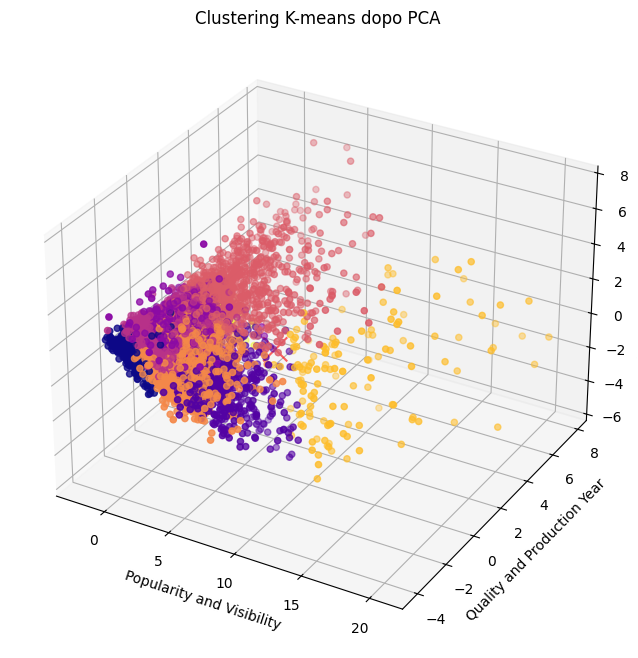

In [4]:
# Visualizza i risultati del clustering su 3 componenti principali (grafico 3D)
fig = plt.figure(figsize=(15, 8))  # Aumenta la larghezza del grafico
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_pca['Popularity and Visibility'], train_pca['Quality and Production Year'], train_pca['Awards and Duration'], c=train_pca['Cluster'], cmap='plasma', marker='o')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', marker='x')
ax.set_title('Clustering K-means dopo PCA')
ax.set_xlabel('Popularity and Visibility')
ax.set_ylabel('Quality and Production Year')
ax.set_zlabel('Awards and Duration')

plt.show()

In [5]:
import seaborn as sns

# Numero di simulazioni per i dati randomizzati
n_simulations = 100
sse_random_results = []
silhouette_random_results = []

# Loop per creare dati randomizzati e calcolare SSE e Silhouette
for _ in range(n_simulations):
    random_data = np.random.permutation(train_data)  # Shuffle dei dati standardizzati
    random_kmeans = KMeans(n_clusters=8, random_state=42)
    random_clusters = random_kmeans.fit_predict(random_data)
    sse_random_results.append(random_kmeans.inertia_)
    silhouette_random_results.append(silhouette_score(random_data, random_clusters))

# SSE e Silhouette Score sui dati reali
sse_real = kmeans.inertia_
silhouette_real = silhouette_score(train_data, clusters)

# # Visualizza i risultati di SSE per i dati reali e randomizzati
# plt.figure(figsize=(12, 10))  # Aumenta la larghezza della figura

# # Plotta gli histogrammi per SSE
# plt.subplot(2, 1, 1)
# sns.histplot(sse_random_results, kde=True, label='Randomized SSE', color='blue', stat='density', bins=10)
# plt.axvline(x=sse_real, color='red', linestyle='--', label='Real SSE')
# plt.legend()
# plt.title('SSE Comparison')

# # Plotta gli histogrammi per Silhouette
# plt.subplot(2, 1, 2)
# sns.histplot(silhouette_random_results, kde=True, label='Randomized Silhouette', color='blue', stat='density', bins=30)
# plt.axvline(x=silhouette_real, color='red', linestyle='--', label='Real Silhouette')
# plt.legend()
# plt.title('Silhouette Score Comparison')

# plt.tight_layout()
# plt.show()

In [6]:
import plotly.graph_objects as go
import plotly.express as px

# Crea istogrammi per SSE
fig_sse = px.histogram(sse_random_results, nbins=10, title='SSE Comparison', histnorm='density')
fig_sse.add_vline(x=sse_real, line=dict(color='red', dash='dash'), annotation_text='Real SSE', annotation_position='top right')

# Crea istogrammi per Silhouette
fig_silhouette = px.histogram(silhouette_random_results, nbins=30, title='Silhouette Score Comparison', histnorm='density')
fig_silhouette.add_vline(x=silhouette_real, line=dict(color='red', dash='dash'), annotation_text='Real Silhouette', annotation_position='top right')

# Aggiorna layout per allargare l'asse x
fig_sse.update_layout(xaxis=dict(range=[min(sse_random_results)-3000, max(sse_random_results)+3000]))
fig_silhouette.update_layout(xaxis=dict(range=[min(silhouette_random_results)-0.03, max(silhouette_random_results)+0.03]))

# Mostra i grafici
fig_sse.show()
fig_silhouette.show()

Vengono scelti 4 cluster perchè il valore del silhoutte score è piu alto di quello randomico mantenendo comunque sse molto piu basso di quelli randomici

In [7]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

n_points = train_pca.shape[0]
#generate distance matrix
distance_matrix = squareform(pdist(train_pca, metric='euclidean')) 

#Otteniamo le etichette di cluster dal modello k-means
labels = kmeans.labels_

#generate ideal similarity matrix
similarity_matrix = np.equal.outer(labels, labels).astype(int)


# Convertiamo la matrice delle distanze in una matrice di similarità
# (simply similarity_matrix = max_distance - distance_matrix)
max_distance = np.max(distance_matrix)
similarity_from_distance = distance_matrix - max_distance 

'''
# Rendi entrambe le matrici 1D per il calcolo della correlazione
similarity_from_distance_flat = similarity_from_distance.flatten()
similarity_matrix_flat = similarity_matrix.flatten()

# Calcola la correlazione di Pearson
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)
'''
# Selezioniamo solo la parte inferiore della matrice, inclusa la diagonale
lower_triangle_indices = np.tril_indices(n_points)

# Appiattiamo solo la parte inferiore della matrice
similarity_from_distance_flat = similarity_from_distance[lower_triangle_indices]
similarity_matrix_flat = similarity_matrix[lower_triangle_indices]

# Calcolare la correlazione di Pearson tra i vettori appiattiti
correlation, _ = pearsonr(similarity_from_distance_flat, similarity_matrix_flat)

print("Correlation between distance and ideal similarity matrices:", correlation)

Correlation between distance and ideal similarity matrices: -0.5954775895093614


In [9]:
principal_components_df = pd.DataFrame(train_pca)
principal_components_df.describe()

,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating,Cluster
count,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,15925.000000
mean,4.640279e-17,-2.097049e-17,5.309550e-17,1.784723e-18,-8.923614e-18,4.293815
std,2.063024e+00,1.196257e+00,1.043604e+00,9.702996e-01,9.016430e-01,2.413412
min,-2.125705e+00,-4.153832e+00,-5.442170e+00,-4.154836e+00,-5.957225e+00,0.000000
25%,-1.222967e+00,-7.264520e-01,-6.123275e-01,-5.709878e-01,-5.172481e-01,2.000000
50%,-6.266554e-01,1.064962e-01,-6.461689e-02,2.753387e-02,3.319548e-02,4.000000
75%,4.488364e-01,7.346950e-01,5.516331e-01,5.937905e-01,5.329868e-01,7.000000
max,2.071558e+01,7.826389e+00,7.451328e+00,8.326927e+00,8.310961e+00,7.000000


In [10]:
# Calcola le statistiche per ciascun cluster
cluster_stats = train_pca.groupby('Cluster').describe()
print("Statistiche per ciascun cluster:")
cluster_stats.transpose().round(2)

Statistiche per ciascun cluster:


Cluster                                  0       1        2        3       4  \
Popularity and Visibility   count  1199.00  764.00  2609.00  2683.00  807.00   
                            mean     -0.97    3.65    -0.37    -0.65    2.78   
                            std       0.76    1.91     0.97     0.95    2.45   
                            min      -2.13    0.53    -1.74    -2.04   -0.91   
                            25%      -1.55    2.21    -1.08    -1.31    0.91   
                            50%      -1.12    3.19    -0.62    -0.94    2.30   
                            75%      -0.52    4.72     0.09    -0.22    4.08   
                            max       3.89   10.23     5.36     4.14   13.47   
Quality and Production Year count  1199.00  764.00  2609.00  2683.00  807.00   
                            mean     -1.29   -0.47     0.02    -0.54    2.10   
                            std       0.83    1.17     0.71     0.77    1.26   
                            min      -3.57   -3.84    -4.08    -3.46   -0.75   
                            25%      -1.94   -1.31    -0.44    -1.08    1.20   
                            50%      -1.25   -0.36     0.05    -0.51    2.00   
                            75%      -0.59    0.40     0.50     0.04    2.81   
                            max       1.07    2.62     1.94     1.81    7.83   
Awards and Duration         count  1199.00  764.00  2609.00  2683.00  807.00   
                            mean      0.22   -1.42     0.41     0.64    2.33   
                            std       0.55    1.05     0.66     0.56    1.10   
                            min      -1.31   -5.44    -1.55    -1.09   -0.54   
                            25%      -0.17   -2.12    -0.02     0.24    1.57   
                            50%       0.19   -1.34     0.36     0.62    2.16   
                            75%       0.57   -0.65     0.73     1.00    2.91   
                            max       2.24    1.38     6.83     2.89    7.45   
Year and Duration           count  1199.00  764.00  2609.00  2683.00  807.00   
                            mean     -1.56    0.92     0.75     0.79   -0.95   
                            std       0.67    0.79     0.74     0.62    0.83   
                            min      -3.67   -1.65    -1.28    -0.80   -4.15   
                            25%      -2.07    0.37     0.30     0.34   -1.44   
                            50%      -1.46    0.88     0.65     0.76   -0.89   
                            75%      -1.00    1.45     1.10     1.18   -0.37   
                            max      -0.20    4.02     8.33     3.23    1.48   
Duration and Rating         count  1199.00  764.00  2609.00  2683.00  807.00   
                            mean     -0.73   -0.51     0.92    -0.81    0.13   
                            std       0.56    0.89     0.78     0.68    0.89   
                            min      -2.95   -4.77    -0.23    -3.70   -2.57   
                            25%      -1.13   -1.03     0.43    -1.24   -0.45   
                            50%      -0.70   -0.46     0.75    -0.70    0.19   
                            75%      -0.32    0.06     1.23    -0.26    0.70   
                            max       0.65    1.95     8.31     0.54    4.95   

Cluster                                  5       6        7  
Popularity and Visibility   count  1892.00  137.00  5834.00  
                            mean      1.07   11.87    -0.82  
                            std       1.63    3.42     0.78  
                            min      -1.69    5.14    -2.09  
                            25%      -0.08    9.58    -1.40  
                            50%       0.64   11.25    -0.99  
                            75%       1.89   13.99    -0.43  
                            max       9.78   20.72     3.63  
Quality and Production Year count  1892.00  137.00  5834.00  
                            mean     -1.37    1.77     0.68  
                            std      